In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})


2. Загрузка данных

In [2]:
train_df = pd.read_csv('train.csv', sep=',')
test_df = pd.read_csv('test.csv', sep=',')

In [3]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

3. Приводим типы данных

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [5]:
train_df.groupby(['DistrictId','Shops_1','Shops_2'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrYear'}) 
            

,DistrictId,Shops_1,Shops_2,MedPriceByDistrYear
0,0,6,B,162985.116572
1,0,8,B,173146.323968
2,1,0,B,105341.507082
3,1,1,B,184084.206044
4,1,2,B,171878.679677
...,...,...,...,...
388,202,5,B,394150.861857
389,205,5,B,220501.566180
390,207,5,B,426186.409334
391,208,4,B,431137.654083


Подготавливаем данные

In [6]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""
        
        #обработка пропусков помечаем все nan префиксм nan
        
        i = 0
        for f in X.isna().sum()>0:
            if f:
                X[(X.keys()[i])+'_nan'] = X[(train_df.keys()[i])].isna() * 1
            i=i+1
        
        # LifeSquare
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        X.fillna(self.medians, inplace=True)
                
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = X['KitchenSquare'] > self.kitchen_square_quantile
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 6, 'KitchenSquare'] = 6
        
        #LifeSquare
        X.loc[X['LifeSquare']<15, 'LifeSquare'] = 15
        
        # Square
        X.loc[X['Square'] < X['LifeSquare'], 'Square'] = X['LifeSquare'] + 3
        X.loc[X['Square'] < X['KitchenSquare'], 'Square'] = X['KitchenSquare'] + 3
              
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > 76, 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] > 76, 'HouseFloor'] = 76
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
         
        X.fillna(self.medians, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        return X

4. Построение новых признаков

In [7]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_rooms = None
        self.med_price_by_district_year = None
        self.med_price_by_floor_rooms_median = None
        self.med_price_by_district_year_median = None
        self.med_price_by_ecology_median = None
        self.house_year_max = datetime.now().year
        self.district_size = None
     
    def floor_to_cat(self, X):
        X['Floor_cat'] = pd.cut(X['Floor'], [0, 2, 4, 6, 9, 76], labels=False)
        #X['Floor_to_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        X['Year_cat'] = pd.cut(X['HouseYear'], [0, self.house_year_max-50, self.house_year_max-40, self.house_year_max-30, self.house_year_max-20, self.house_year_max-10, self.house_year_max], labels=False)
        #X['Year_to_cat'].fillna(-1, inplace=True)
        return X
    
    def fit(self, X, y=None):       
        
        #создаем датафрейм и добовляем 2 категориальных признака Floor_to_cat, Year_to_cat
        df = X.copy()   
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)
        
        # DistrictID
        self.district_size = X.DistrictId.value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## Floor, Rooms
        
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_floor_rooms = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByRooms'})
            self.med_price_by_floor_rooms_median = self.med_price_by_floor_rooms['MedPriceByRooms'].median()
            
        ## District, year
            self.med_price_by_district_year = df.groupby(['DistrictId', 'Year_cat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrYear'}) 
            self.med_price_by_district_year_median = self.med_price_by_district_year['MedPriceByDistrYear'].median()
            
        ## Ecology
            self.med_price_by_ecology = df.groupby(['DistrictId', 'Ecology_1', 'Ecology_2', 'Ecology_3'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByEcology'}) 
            self.med_price_by_ecology_median = self.med_price_by_ecology['MedPriceByEcology'].median()
            
        ## Shops
            self.med_price_by_shops = df.groupby(['DistrictId', 'Shops_1', 'Shops_2'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByShops'}) 
            self.med_price_by_shops_median = self.med_price_by_shops['MedPriceByShops'].median() 
            
    def transform(self, X):     
        
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        new_district_size = X['new_district'].loc[X['new_district']==1].shape[0]
        X['DistrictSize'].fillna(new_district_size, inplace=True)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)
        
        # Target encoding
        if self.med_price_by_floor_rooms_median is not None:
            X = X.merge(self.med_price_by_floor_rooms, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByRooms'].fillna(self.med_price_by_floor_rooms_median, inplace=True)
           
        if self.med_price_by_district_year_median is not None:
            X = X.merge(self.med_price_by_district_year, on=['DistrictId', 'Year_cat'], how='left')
            X['MedPriceByDistrYear'].fillna(self.med_price_by_district_year_median, inplace=True)
        
        if self.med_price_by_ecology_median is not None:
            X = X.merge(self.med_price_by_ecology, on=['DistrictId', 'Ecology_1', 'Ecology_2', 'Ecology_3'], how='left')
            X['MedPriceByEcology'].fillna(self.med_price_by_ecology_median, inplace=True)
           
        if self.med_price_by_shops_median is not None:
            X = X.merge(self.med_price_by_shops, on=['DistrictId', 'Shops_1', 'Shops_2'], how='left')
            X['MedPriceByShops'].fillna(self.med_price_by_shops_median, inplace=True)
            
        return X

5. Отбор признаков

In [8]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [9]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2']
                 
new_feature_names = [ 'DistrictSize', 'MedPriceByShops', 'MedPriceByEcology']                 
target_name = 'Price'

6. Разбиение на train и test

In [10]:
x = train_df.drop(columns=target_name)
y = train_df[target_name]

In [11]:
#fg.med_price_by_ecology

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, shuffle=True, random_state=21)

In [13]:
dp = DataPreprocessing()
dp.fit(x_train)
x_train = dp.transform(x_train)
x_valid = dp.transform(x_valid)
test_df = dp.transform(test_df)
fg = FeatureGenetator()
fg.fit(x_train, y_train)
x_train = fg.transform(x_train)
x_valid = fg.transform(x_valid)
test_df = fg.transform(test_df)

In [14]:
x_train = x_train[feature_names + new_feature_names]
x_valid = x_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [15]:
x_train.isna().sum().sum(), x_valid.isna().sum().sum(), test_df.isna().sum().sum()


(0, 0, 0)

7. Построение модели

Обучение

In [16]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(x_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Оценка модели

In [17]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.964
Test R2:	0.728


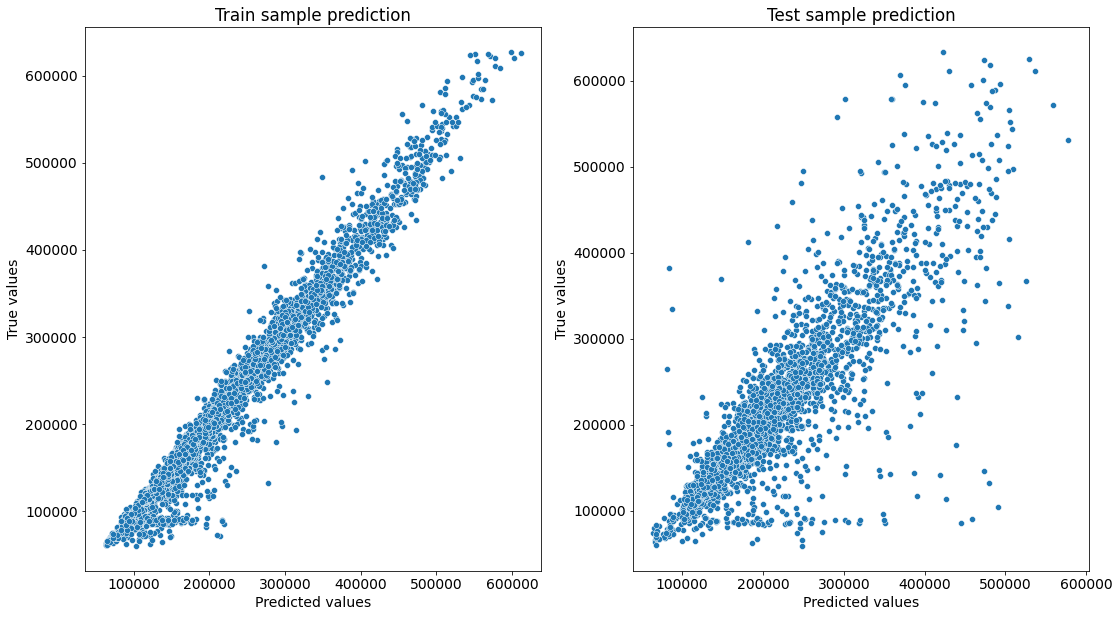

In [18]:
y_train_preds = rf_model.predict(x_train)
y_test_preds = rf_model.predict(x_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [19]:
cv_score = cross_val_score(rf_model, x_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75425085, 0.70516648, 0.74008994])

In [20]:
cv_score.mean()

0.7331690875959677

Важность признаков

In [21]:
feature_importances = pd.DataFrame(zip(x_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.400079
16,MedPriceByShops,0.221808
17,MedPriceByEcology,0.134372
2,LifeSquare,0.036922
0,Rooms,0.033363
6,HouseYear,0.027895
15,DistrictSize,0.021295
12,Social_3,0.019923
4,Floor,0.019821
5,HouseFloor,0.018352
